In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt install tree htop > /dev/null

# Install Required Packages

In [ ]:
! pip install sentence-transformers > /dev/null

In [ ]:
! pip install faiss-gpu > /dev/null

In [ ]:
! pip install h3 > /dev/null

In [ ]:
! pip install optuna > /dev/null

In [ ]:
!nvidia-smi

Fri Jul  1 07:50:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import math
import pathlib
import unicodedata as ud

from enum import Enum
from functools import partial
from sys import getsizeof

import faiss
import h3
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow.parquet as pq
import pyarrow as pa
import sentence_transformers

from numpy import sin, cos, deg2rad, rad2deg
from numpy.linalg import inv
from pandas import CategoricalDtype
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from tqdm.auto import tqdm

pd.set_option("max_colwidth", 900)
pd.set_option("max_rows", 100)
plt.style.use("ggplot")

In [ ]:
class CFG:
    H3_COL = "h3_res1"
    MODELS = {
        "stsb-xlm-r-multilingual": "sentence-transformers/stsb-xlm-r-multilingual",
        "all-mpnet-base-v2": "sentence-transformers/all-mpnet-base-v2",
        "all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
        "all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
        "all-MiniLM-L12-v2": "sentence-transformers/all-MiniLM-L12-v2",
    }
    MODEL_KEY = "all-MiniLM-L6-v2"
    EMBEDDING_KEYS = ["name", "categories"]
    EMBEDDING_MODEL = MODELS[MODEL_KEY]
    RANDOM_SEED = 1234

In [ ]:
%%time
DATA = pathlib.Path("/content/drive/My Drive/Competition/4sq/data")

train = pq.read_table(f"{DATA}/train.parquet").to_pandas()
h3_df = pq.read_table(f"{DATA}/h3.parquet").to_pandas()
train = train.merge(h3_df, on="id")
del h3_df

CPU times: user 4.47 s, sys: 1.39 s, total: 5.86 s
Wall time: 9.2 s


In [ ]:
def get_mem_size(data):
    size_bytes = getsizeof(data)
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [ ]:
print(f"memory size of train: {get_mem_size(train)}")

memory size of train: 1.18 GB


In [ ]:
def drop_na(df, cols):
    print(f"drop NaN {cols}:")
    df = df.dropna(subset=cols)
    return df

drop_na_name = partial(drop_na, cols=["name"])

In [ ]:
def normalize(df, cols):
    print(f"normalize: {cols}")
    df = df.copy()
    for col in cols:
        ser = df[col]
        ser = ser.str.lower()
        ser = ser.str.replace("\s", " ", regex=True)
        ser = ser.str.replace(" +", " ", regex=True)
        ser = ser.str.replace("^ $", "", regex=True)
        df[f"{col}"] = ser

        print(f"  #blank rows in {col}: {len(df[df[col] == '']):,}")
    return df


normalize_cols = partial(normalize, cols=["name", "categories", "address"])

In [ ]:
def fill_na(df, cols):
    df = df.copy()
    df[cols] = df[cols].fillna("")
    return df


fill_na_cols = partial(fill_na, cols=["name", "categories", "address"])

In [ ]:
def drop_duplicated(df, cols):
    print(f"drop duplicated {cols}:")
    print(f"  #locations before: {len(df):,}")
    df = df.drop_duplicates(cols)
    print(f"  #locations after: {len(df):,}")
    return df

drop_duplicated_name = partial(drop_duplicated, cols=["name"])

In [ ]:
def drop_single_poi(df):
    print("drop single POI:")
    poi_df = df.groupby("point_of_interest").agg(count=("id", "count")).reset_index()
    print(f"  #POIs before: {len(poi_df):,}")
    poi_df = poi_df.query("count > 1")
    print(f"  #POIs after: {len(poi_df):,}")
    pois = set(poi_df["point_of_interest"].to_numpy())
    print(f"  #locations before: {len(df):,}")
    df = df.query("point_of_interest in @pois")
    print(f"  #locations after: {len(df):,}")
    return df

In [ ]:
def compose(transforms):
    def transform_func(df):
        for transform in transforms:
            df = transform(df)
        return df

    return transform_func

In [ ]:
def dev_test_split(df, test_size=0.5, random_state=1234):
    poi_df = df.groupby("point_of_interest").agg(count=("id", "count")).reset_index()
    pois = poi_df.index.to_numpy()
    idx_dev, idx_test, _, _ = train_test_split(pois, np.zeros_like(pois), test_size=test_size, random_state=random_state)
    pois_dev = set(poi_df.loc[idx_dev, "point_of_interest"].to_list())
    pois_test = set(poi_df.loc[idx_test, "point_of_interest"].to_list())
    df_dev = df.query("point_of_interest in @pois_dev")
    df_test = df.query("point_of_interest in @pois_test")
    return df_dev, df_test

In [ ]:
transforms = compose([drop_na_name, fill_na_cols, normalize_cols, drop_duplicated_name, drop_single_poi])

In [ ]:
%%time
train_ext = transforms(train)

drop NaN ['name']:
normalize: ['name', 'categories', 'address']
  #blank rows in name: 0
  #blank rows in categories: 98,306
  #blank rows in address: 396,620
drop duplicated ['name']:
  #locations before: 1,138,811
  #locations after: 817,238
drop single POI:
  #POIs before: 601,975
  #POIs after: 169,687
  #locations before: 817,238
  #locations after: 384,950
CPU times: user 14.5 s, sys: 380 ms, total: 14.9 s
Wall time: 14.8 s


In [ ]:
train_dev, train_test = dev_test_split(train_ext, random_state=CFG.RANDOM_SEED)

In [ ]:
len(train_dev), len(train_test)

(192549, 192401)

In [ ]:
assert len(train_dev[train_dev["categories"].isna()]) == 0
assert len(train_test[train_test["categories"].isna()]) == 0

In [ ]:
del train

In [ ]:
def plot_fill_ratio(df):
    fig, ax = plt.subplots()
    df_ = (1 - (df.isna().sum(axis=0) / len(df))).reset_index()
    sns.barplot(data=df_, x=0, y="index", ax=ax)
    ax.set(title="Proportion of filled rows", xlabel="proportion", ylabel=None)
    plt.show()
    print(df_)

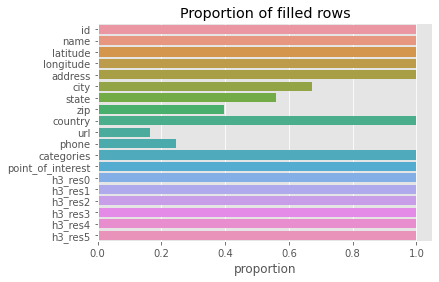

                index         0
0                  id  1.000000
1                name  1.000000
2            latitude  1.000000
3           longitude  1.000000
4             address  1.000000
5                city  0.672109
6               state  0.561114
7                 zip  0.397385
8             country  1.000000
9                 url  0.164805
10              phone  0.246633
11         categories  1.000000
12  point_of_interest  1.000000
13            h3_res0  1.000000
14            h3_res1  1.000000
15            h3_res2  1.000000
16            h3_res3  1.000000
17            h3_res4  1.000000
18            h3_res5  1.000000


In [ ]:
plot_fill_ratio(train_dev)

In [ ]:
def plot_num_record(df, top_n=10):
    vc = df["country"].value_counts()
    fig, ax = plt.subplots()
    ax.plot(vc.cumsum() / vc.sum())
    ax.set(
        xscale="log",
        xlabel="number of record",
        ylabel="Proportion",
        title="Cumulative plot of #country",
    )
    plt.show()
    print(vc[:top_n].cumsum() / vc.sum())

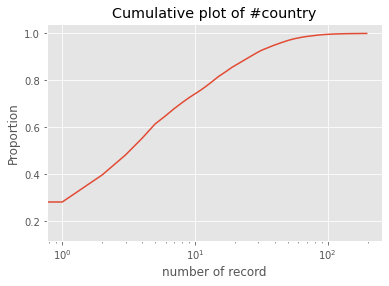

US    0.157077
TR    0.281305
ID    0.396803
JP    0.482251
TH    0.553293
RU    0.613698
MY    0.648718
BR    0.680144
BE    0.704782
KR    0.725675
Name: country, dtype: float64


In [ ]:
plot_num_record(train_dev)

# H3 segments

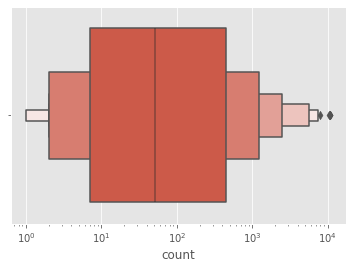

In [ ]:
vc = train_dev.value_counts(CFG.H3_COL)
fig, ax = plt.subplots()
df = pd.DataFrame({"count": vc})
sns.boxenplot(data=df, x="count", ax=ax)
ax.set(xscale="log")
plt.show()

# Sort DataFrame by H3 ids

In [ ]:
def sort_by_h3(df, col):
    df = df.copy()
    vc = df.value_counts(col)
    vc_df = pd.DataFrame({"count": vc}).reset_index()
    cat = pd.CategoricalDtype(vc_df[col], ordered=True)
    df[col] = pd.Categorical(df[col].astype(cat))
    df.sort_values(col, inplace=True)
    df = df.reset_index(drop=True)
    return df

In [ ]:
train_dev_sorted = sort_by_h3(train_dev, CFG.H3_COL)
train_test_sorted = sort_by_h3(train_test, CFG.H3_COL)

In [ ]:
assert len(train_dev_sorted[train_dev_sorted["categories"].isna()]) == 0
assert len(train_test_sorted[train_test_sorted["categories"].isna()]) == 0

# Calculate Embeddings

In [ ]:
def calc_embeddings(model, df, col, batch_size=256):
    sentences = df[col].to_numpy()
    embeddings = model.encode(sentences, show_progress_bar=True, batch_size=batch_size)

    return embeddings

In [ ]:
def create_gpos(df):
    lat = df["latitude"].apply(deg2rad).to_numpy(dtype=np.float32)
    lon = df["longitude"].apply(deg2rad).to_numpy(dtype=np.float32)
    x = cos(lat) * cos(lon)
    y = cos(lat) * sin(lon)
    z = sin(lat)
    gpos = np.stack([x, y, z], axis=-1)
    return gpos

In [ ]:
def replace_category_sep(df, col="categories"):
    df = df.copy()
    df[col] = df[col].str.replace(", ", " [SEP] ")
    return df

In [ ]:
def eliminate_mean_embedding(embeddings):
    return embeddings - embeddings.mean(axis=0, keepdims=True)

In [ ]:
def normalize_L2(embeddings):
    return embeddings / ((embeddings**2).sum(axis=1) ** 0.5).reshape(-1, 1)

In [ ]:
train_dev_sep = replace_category_sep(train_dev_sorted)
train_test_sep = replace_category_sep(train_test_sorted)

In [ ]:
assert len(train_dev_sep[train_dev_sep["categories"].isna()]) == 0
assert len(train_test_sep[train_test_sep["categories"].isna()]) == 0

In [ ]:
gpos_dev = create_gpos(train_dev_sep)
gpos_test = create_gpos(train_test_sep)

In [ ]:
model = SentenceTransformer(CFG.EMBEDDING_MODEL)
embeddings_list_dev = [
    calc_embeddings(model, train_dev_sep, "name"),
    calc_embeddings(model, train_dev_sep, "categories"),
]
embeddings_list_test = [
    calc_embeddings(model, train_test_sep, "name"),
    calc_embeddings(model, train_test_sep, "categories"),
]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/753 [00:00<?, ?it/s]

Batches:   0%|          | 0/753 [00:00<?, ?it/s]

Batches:   0%|          | 0/752 [00:00<?, ?it/s]

Batches:   0%|          | 0/752 [00:00<?, ?it/s]

In [ ]:
def transform_embedding(embeddings_list):
    embeddings_list_gm = [ebd.copy() for ebd in embeddings_list]
    embeddings_list_gm = [eliminate_mean_embedding(embds) for embds in embeddings_list]

    embeddings_list_gm_norm = [ebd.copy() for ebd in embeddings_list_gm]
    embeddings_list_gm_norm = [normalize_L2(embds) for embds in embeddings_list_gm_norm]

    return embeddings_list_gm_norm

In [ ]:
embeddings_list_dev_gm_norm = transform_embedding(embeddings_list_dev)
embeddings_list_test_gm_norm = transform_embedding(embeddings_list_test)

In [ ]:
embeddings_dev_gm_norm = np.concatenate(embeddings_list_dev_gm_norm, axis=1)
embeddings_test_gm_norm = np.concatenate(embeddings_list_test_gm_norm, axis=1)
embeddings_dev_gm_norm.shape, embeddings_test_gm_norm.shape

((192549, 768), (192401, 768))

## numpy.memmap

In [ ]:
embeddings_dev_mmp = np.memmap(f"embedding_dev_gm_norm_{CFG.H3_COL}.dat", dtype=np.float32, mode='w+', shape=embeddings_dev_gm_norm.shape)
embeddings_dev_mmp[:] = embeddings_dev_gm_norm[:]

embeddings_test_mmp = np.memmap(f"embedding_test_gm_norm_{CFG.H3_COL}.dat", dtype=np.float32, mode='w+', shape=embeddings_test_gm_norm.shape)
embeddings_test_mmp[:] = embeddings_test_gm_norm[:]

# Split Pos/Neg

In [ ]:
def concat_embeddings(embeddings_list, weights):
    assert len(embeddings_list) == len(weights)
    return np.concatenate(
        [w * ebd for ebd, w in zip(embeddings_list, weights)], axis=-1
    )

In [ ]:
class kNN:
    def __init__(self, k_neighbor, normalize=True):
        self.k_neighbor = k_neighbor
        self.index = None
        self.normalize = normalize

    def fit(self, X):
        dims = X.shape[-1]
        X = np.ascontiguousarray(X)

        if self.normalize:
            faiss.normalize_L2(X)
        res = faiss.StandardGpuResources()
        flat_config = faiss.GpuIndexFlatConfig()
        flat_config.device = 0
        flat_config
        index = faiss.GpuIndexFlatL2(res, dims, flat_config)
        index.add(X)
        self.index = index

    def search(self, Xq):
        Xq = np.ascontiguousarray(Xq)
        if self.normalize:
            faiss.normalize_L2(Xq)
        D, I = self.index.search(Xq, self.k_neighbor)
        return I, D

In [ ]:
class Predictor:
    def __init__(self, k_neighbor=25, normalize=True):
        self.k_neighbor = k_neighbor
        self.normalize = normalize

    def predict(self, search, query, idx2id):
        assert query.shape[-1] == search.shape[-1]
        assert query.shape[0] <= search.shape[0], f"{query.shape[0]} {search.shape[0]}"

        knn = kNN(self.k_neighbor, self.normalize)
        knn.fit(search)

        I, D = knn.search(query)
        preds = I.tolist()
        distances = D.tolist()
        preds = [[idx2id[p] for p in pred] for pred in preds]
        return preds, distances

In [ ]:
def create_gts(df, col="id"):
    gt_df = (
        df.groupby("point_of_interest").agg(gt=(col, lambda x: list(x))).reset_index()
    )
    df = pd.merge(df, gt_df, on="point_of_interest", how="left")
    gts = df["gt"].to_numpy()
    return gts

In [ ]:
def evaluate(preds, gts, eps=1e-15):
    preds_ = [set(pred) for pred in preds]
    gts_ = [set(gt) for gt in gts]
    intersections = [pred.intersection(gt) for pred, gt in zip(preds_, gts_)]
    unions = [pred.union(gt) for pred, gt in zip(preds_, gts_)]
    ious = [
        len(intersec) / len(union) for intersec, union in zip(intersections, unions)
    ]
    recalls = [len(intersec) / len(gt) for intersec, gt in zip(intersections, gts_)]
    precisions = [
        len(intersec) / len(pred) for intersec, pred in zip(intersections, preds_)
    ]
    f1 = np.mean([2 * r * p / (r + p + eps) for r, p in zip(recalls, precisions)])

    result = {
        "IoU": np.mean(ious),
        "Recall": np.mean(recalls),
        "Precision": np.mean(precisions),
        "F1": f1,
    }

    return result

In [ ]:
class Logger:
    def __init__(self, is_debug=True):
        self.is_debug = is_debug

    def set_debug(self, is_debug):
        self.is_debug = is_debug

    def log(self, text):
        if self.is_debug:
            print(text)

In [ ]:
def get_search_points(origin):
    s1, s2 = h3.k_ring_distances(origin, 1)
    return list(s1.union(s2))

def set_exponential_monitor(logger, n):
    if n < 10:
        is_monitor = True
    elif n < 100:
        is_monitor = n % 10 == 0
    elif n < 1000:
        is_monitor = n % 100 == 0
    else:
        is_monitor = n % 1000 == 0

    logger.set_debug(is_monitor)

def simple_eval(recalls, weights, n_total):
    return np.sum([r * w for r, w in zip(recalls, weights)]) / np.sum(weights)


def evaluate_all(df, embeddings_list, weight_list, k=25, normalize=True, monitor=True, debug_iter=0):
    grouped = df.groupby(CFG.H3_COL)
    vc = df.value_counts(CFG.H3_COL)
    origin2sp = {origin: get_search_points(origin) for origin in vc.keys()}
    point_set = set(df[CFG.H3_COL].unique().tolist())
    logger = Logger()

    recalls = []
    weights = []
    h3_res4s = []
    preds_list = []
    ids_list = []
    distances_list = []
    score = 0.0
    weight_processed = 0.0

    n = 0
    for i, (origin, query_df) in enumerate(tqdm(grouped)):
        if debug_iter > 0:
            if i > debug_iter:
                continue
        n += 1
        if monitor:
            set_exponential_monitor(logger, n)
        else:
            logger.set_debug(False)

        logger.log("=" * 36 + f" ROUND {i + 1} " + "=" * 36)
        logger.log(f"Constructing search & query of {origin}:")
        query_df = query_df.reset_index()
        search_points = origin2sp[origin]
        search_points = [pt for pt in search_points if pt in point_set]
        search_df = pd.concat([grouped.get_group(pt) for pt in search_points])
        search_df = search_df.reset_index()
        query_set = set(query_df[CFG.H3_COL].unique().tolist())
        query_idx = search_df.query(f"{CFG.H3_COL} in @query_set").index

        logger.log(f"  - #points in query: {len(query_df)}")
        logger.log(f"  - #points in search space: {len(search_df)}")

        k_neighbor = min(len(search_df), k)
        if len(search_df) > 1:
            logger.log("Calculate Embeddings:")
            global_search_index = search_df["index"].to_numpy()

            embeddings_local = [embds[global_search_index].copy() for embds in embeddings_list]

            embeddings_concat = concat_embeddings(embeddings_local, weight_list)
            search = embeddings_concat
            query = search[query_idx]

            predictor = Predictor(k_neighbor=k_neighbor, normalize=normalize)
            idx2id = search_df["id"].to_dict()
            preds, distances = predictor.predict(search, query, idx2id)
        else:
            logger.log("Skip calculating Embeddings:")
            preds = search_df["id"].to_numpy().reshape(1, -1).tolist()
            distances = [[0.0]]
        
        logger.log(f"  - len(pred[0]): {len(preds[0])}")
        logger.log("Evaluation without post process:")        
        gts = create_gts(query_df)
        result = evaluate(preds, gts, eps=1e-15)
        logger.log(
            ", ".join([f"{key}: {value:.4f}" for key, value in result.items()])
        )

        recall = result["Recall"]
        weight = len(query_df)
        score += weight * recall
        weight_processed += weight
        logger.log(f"score (running mean): {score / weight_processed:4f}")
        logger.log(f"processed: {weight_processed / len(df):4f}")

        recalls.append(recall)
        weights.append(weight)
        h3_res4s.append(origin)
        preds_list.append(preds)
        ids_list.append(query_df["id"].to_numpy())
        distances_list.append(distances)
    
    score = simple_eval(recalls, weights, len(df))
    if monitor:
        print("=" * 80)
        print(f"approximate score: {score:.4f}")
        print(f"processed: {sum(weights) / len(df):.4f}")

    return score, recalls, weights, h3_res4s, preds_list, ids_list, distances_list

In [ ]:
def objective_factory(train_ext, embeddings_list):
    def objective(trial):
        alpha = trial.suggest_float("alpha", 0, 1)
        score, recalls, weights, h3_res4s, preds_list, ids_list, distances_list = \
            evaluate_all(train_ext, embeddings_list, [1, alpha], k=25, normalize=True, monitor=False, debug_iter=10)
        return -score
    return objective

In [ ]:
ebd_list_dev = [embeddings_dev_mmp[:, :384], embeddings_dev_mmp[:, 384:768]]

In [ ]:
objective = objective_factory(train_dev_sep, ebd_list_dev)
study = optuna.create_study()
study.optimize(objective, n_trials=15)
alpha_opt = study.best_params["alpha"]
best_score = study.best_value

In [ ]:
alpha_opt, -best_score

(0.34255009674469794, 0.788716560594284)

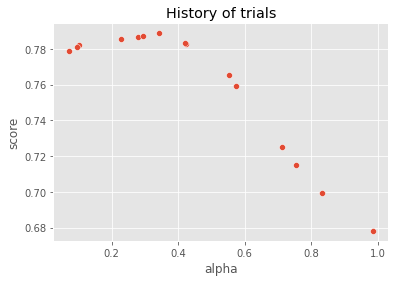

In [ ]:
trials = study.get_trials()
y, x1 = zip(*[(-t.values[0], t.params["alpha"]) for t in trials])
df = pd.DataFrame({"alpha": x1, "score": y})

ax = sns.scatterplot(data=df, x="alpha", y="score")
ax.set(title=f"History of trials")
plt.show()

## Train set

In [ ]:
def blocking(df, embeddings_list, weights):
    score, recalls, weights, h3_res4s, preds_list, ids_list, distances_list = \
        evaluate_all(df, embeddings_list, weights, k=25, normalize=True, monitor=True, debug_iter=0)
    
    preds_flat, ids_flat, distances_flat = [], [], []
    for ids, preds, distances in zip(ids_list, preds_list, distances_list):
        preds_flat.extend(preds)
        ids_flat.extend(ids)
        distances_flat.extend(distances)

    preds_df = pd.DataFrame({"id": ids_flat, "preds": preds_flat, "distances": distances_flat})
    stat_df = pd.DataFrame({CFG.H3_COL: h3_res4s, "recall": recalls, "weight": weights})

    return preds_df, stat_df

In [ ]:
preds_dev_df, stat_dev_df = blocking(train_dev_sep, ebd_list_dev, [1, alpha_opt])

  0%|          | 0/295 [00:00<?, ?it/s]

==================================== ROUND 1 ====================================
Constructing search & query of 81653ffffffffff:
  - #points in query: 10817
  - #points in search space: 22741
Calculate Embeddings:
  - len(pred[0]): 25
Evaluation without post process:
IoU: 0.0903, Recall: 0.8499, Precision: 0.0951, F1: 0.1609
score (running mean): 0.849905
processed: 0.056178
==================================== ROUND 2 ====================================
Constructing search & query of 818c3ffffffffff:
  - #points in query: 10791
  - #points in search space: 18267
Calculate Embeddings:
  - len(pred[0]): 25
Evaluation without post process:
IoU: 0.1278, Recall: 0.7824, Precision: 0.1544, F1: 0.2149
score (running mean): 0.816176
processed: 0.112221
==================================== ROUND 3 ====================================
Constructing search & query of 812d3ffffffffff:
  - #points in query: 10601
  - #points in search space: 30095
Calculate Embeddings:
  - len(pred[0]): 25
Evalua

In [ ]:
preds_dev_pa = pa.Table.from_pandas(preds_dev_df)
ebkeys = "_".join(CFG.EMBEDDING_KEYS)
pq.write_table(preds_dev_pa, f"preds_dev_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.parquet")

In [ ]:
stat_dev_df.to_csv(f"stat_dev_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.csv", index=False)

In [ ]:
!cp preds_dev_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.parquet "{DATA}/"

In [ ]:
!cp stat_dev_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.csv "{DATA}/"

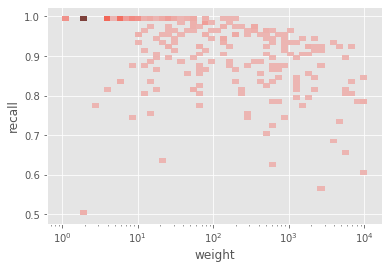

CPU times: user 354 ms, sys: 10.2 ms, total: 364 ms
Wall time: 359 ms


In [ ]:
%%time
ax = sns.histplot(data=stat_dev_df, x="weight", y="recall", log_scale=(True, False), bins=50)
ax.set(xscale="log")
plt.show()

## Test set

In [ ]:
ebd_list_test = [embeddings_test_mmp[:, :384], embeddings_test_mmp[:, 384:768]]

In [ ]:
preds_test_df, stat_test_df = blocking(train_test_sep, ebd_list_test, [1, alpha_opt])

  0%|          | 0/298 [00:00<?, ?it/s]

==================================== ROUND 1 ====================================
Constructing search & query of 81653ffffffffff:
  - #points in query: 10673
  - #points in search space: 22857
Calculate Embeddings:
  - len(pred[0]): 25
Evaluation without post process:
IoU: 0.0889, Recall: 0.8523, Precision: 0.0919, F1: 0.1591
score (running mean): 0.852302
processed: 0.055473
==================================== ROUND 2 ====================================
Constructing search & query of 8165bffffffffff:
  - #points in query: 10561
  - #points in search space: 24958
Calculate Embeddings:
  - len(pred[0]): 25
Evaluation without post process:
IoU: 0.0546, Recall: 0.5817, Precision: 0.0565, F1: 0.1014
score (running mean): 0.717721
processed: 0.110363
==================================== ROUND 3 ====================================
Constructing search & query of 812d3ffffffffff:
  - #points in query: 10254
  - #points in search space: 29831
Calculate Embeddings:
  - len(pred[0]): 25
Evalua

In [ ]:
preds_test_pa = pa.Table.from_pandas(preds_test_df)
ebkeys = "_".join(CFG.EMBEDDING_KEYS)
pq.write_table(preds_test_pa, f"preds_test_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.parquet")

In [ ]:
stat_test_df.to_csv(f"stat_test_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.csv", index=False)

In [ ]:
!cp preds_test_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.parquet "{DATA}/"

In [ ]:
!cp stat_test_{CFG.H3_COL}_{ebkeys}_{CFG.MODEL_KEY}_text_seed{CFG.RANDOM_SEED}.csv "{DATA}/"

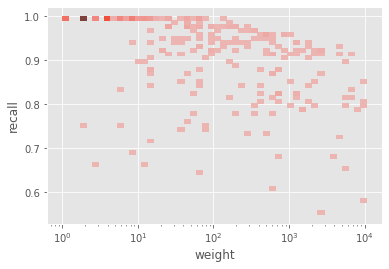

CPU times: user 394 ms, sys: 14.4 ms, total: 409 ms
Wall time: 403 ms


In [ ]:
%%time
ax = sns.histplot(data=stat_test_df, x="weight", y="recall", log_scale=(True, False), bins=50)
ax.set(xscale="log")
plt.show()